The execution results of the code `FC.cxx` are located under `Task2Code/output`. In this notebook we plot the results. As we know the file `V3.sticks.out` contains the spectrum as sticks (i.e. it just contains the position and height of maximums), while the file `V3.spec.out` contains the Lorentzian smoothed version of the spectrum.

First let us import necessary python packages for this plotting.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

Now we import the files `V3.sticks.out` and `V3.spec.out` into numpy arrays, so that we can plot them.

In [2]:
sticks = np.loadtxt("Task2Code/output/V3.sticks.out", delimiter=" ")
spec = np.loadtxt("Task2Code/output/V3.spec.out", delimiter="  ")

Now, it's time to plot! Let us first plot the sticks and spec on two different plots.

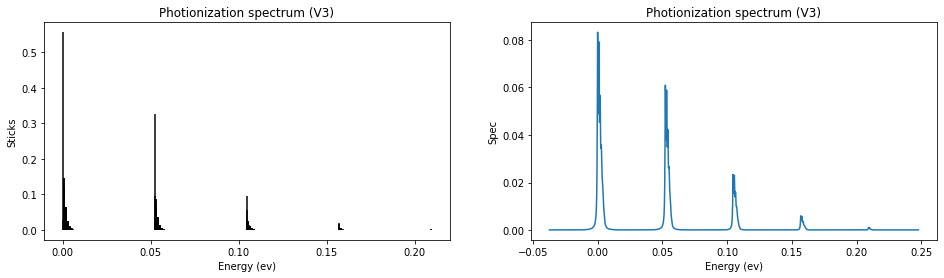

In [22]:
invcm_to_ev = 0.000123984

plt.figure(figsize=(16, 4))
plt.subplot(1, 2, 1)
plt.vlines(invcm_to_ev * sticks[:, 0], 0, sticks[:, 1])
plt.title('Photionization spectrum (V3)')
plt.xlabel('Energy (ev)')
plt.ylabel('Sticks')

plt.subplot(1, 2, 2)
plt.plot(invcm_to_ev * spec[:, 0], spec[:, 1])
plt.title('Photionization spectrum (V3)')
plt.xlabel('Energy (ev)')
plt.ylabel('Spec')

plt.show()

TODO:
1. Clarify the units of energy. They seem to be in 1/cm. Convert energy to ev (electron volt), so that all plots in this project are in electron volt.
2. Clarify the contents of the `sticks` and `spec` files. Are they the FC factors, or Boltzman weighted FC factors, or what? In the tex/pdf output they have the relative FC factors and signal (Boltzman * FC), so we can figure out the connection of `sticks` and `spec` by examining the pdf file.
